In [58]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

### Dataset

In [2]:
data =  'https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv'

In [3]:
!wget -O data.csv $data

--2025-10-19 20:38:56--  https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 80876 (79K) [text/plain]
Saving to: ‘data.csv’

data.csv            100%[===================>]  78.98K  --.-KB/s    in 0.1s    

2025-10-19 20:38:56 (714 KB/s) - ‘data.csv’ saved [80876/80876]



In [4]:
df = pd.read_csv('data.csv')
df.head()

,lead_source,industry,number_of_courses_viewed,annual_income,employment_status,location,interaction_count,lead_score,converted
0,paid_ads,NaN,1,79450.0,unemployed,south_america,4,0.94,1
1,social_media,retail,1,46992.0,employed,south_america,1,0.80,0
2,events,healthcare,5,78796.0,unemployed,australia,3,0.69,1
3,paid_ads,retail,2,83843.0,NaN,australia,1,0.87,0
4,referral,education,3,85012.0,self_employed,europe,3,0.62,1


### Data preparation

In [6]:
df.isnull().sum()

lead_source                 128
industry                    134
number_of_courses_viewed      0
annual_income               181
employment_status           100
location                     63
interaction_count             0
lead_score                    0
converted                     0
dtype: int64

In [7]:
df.dtypes

lead_source                  object
industry                     object
number_of_courses_viewed      int64
annual_income               float64
employment_status            object
location                     object
interaction_count             int64
lead_score                  float64
converted                     int64
dtype: object

In [10]:
df.lead_source = df.lead_source.fillna('NA')
df.industry = df.industry.fillna('NA')
df.annual_income = df.annual_income.fillna(0.0)
df.employment_status = df.employment_status.fillna('NA')
df.location = df.location.fillna('NA')

In [12]:
from sklearn.model_selection import train_test_split

In [14]:
random_state = 1

In [15]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=random_state)
len(df_full_train), len(df_test)

(1169, 293)

In [16]:
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=random_state)
len(df_train), len(df_val), len(df_test)

(876, 293, 293)

In [17]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [18]:
y_train = df_train.converted.values
y_val = df_val.converted.values
y_test = df_test.converted.values

In [19]:
df_train = df_train.drop(columns=['converted'])
df_val = df_val.drop(columns=['converted'])
df_test = df_test.drop(columns=['converted'])

In [38]:
categorical_vars = ['lead_source', 'industry', 'employment_status', 'location']
numerical_vars = ['number_of_courses_viewed', 'annual_income', 'interaction_count', 'lead_score']

### Question 1: ROC AUC feature importance

ROC AUC could also be used to evaluate feature importance of numerical variables. 

Let's do that

* For each numerical variable, use it as score (aka prediction) and compute the AUC with the `y` variable as ground truth.
* Use the training dataset for that


If your AUC is < 0.5, invert this variable by putting "-" in front

(e.g. `-df_train['balance']`)

AUC can go below 0.5 if the variable is negatively correlated with the target variable. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

Which numerical variable (among the following 4) has the highest AUC?

- `lead_score`
- `number_of_courses_viewed`
- `interaction_count`
- `annual_income`



In [ ]:
from sklearn.metrics import roc_auc_score

In [34]:
for feature in numerical_vars:
    scores = df_train[feature].values
    auc = roc_auc_score(y_train, scores)
    if auc < 0.5:
        auc = roc_auc_score(y_train, -scores)
        print(f"{feature}: {auc:.3f} (inverted)")
    else:
        print(f"{feature}: {auc:.3f}")


number_of_courses_viewed: 0.764
annual_income: 0.552
interaction_count: 0.738
lead_score: 0.614


### Question 2: Training the model

Apply one-hot-encoding using `DictVectorizer` and train the logistic regression with these parameters:

```python
LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
```

What's the AUC of this model on the validation dataset? (round to 3 digits)

- 0.32
- 0.52
- 0.72
- 0.92

In [42]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

In [50]:
train_vars = numerical_vars + categorical_vars

In [44]:
X_train_num = df_train[numerical_vars]
X_val_num = df_val[numerical_vars]

scaler = StandardScaler()
X_train_num = scaler.fit_transform(X_train_num)
X_val_num = scaler.transform(X_val_num)


In [48]:
X_train_cat = df_train[categorical_vars]
X_val_cat = df_val[categorical_vars]

train_dicts = X_train_cat.to_dict(orient='records')
val_dicts = X_val_cat.to_dict(orient='records')

dv = DictVectorizer(sparse=False)
X_train_cat = dv.fit_transform(train_dicts)
X_val_cat = dv.transform(val_dicts)

In [51]:
X_train = np.column_stack([X_train_num, X_train_cat])
X_val = np.column_stack([X_val_num, X_val_cat])

In [52]:
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

y_val_pred_proba = model.predict_proba(X_val)[:, 1]
round(roc_auc_score(y_val, y_val_pred_proba), 3)

0.921

### Question 3: Precision and Recall

Now let's compute precision and recall for our model.

* Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
* For each threshold, compute precision and recall
* Plot them

At which threshold precision and recall curves intersect?

* 0.145
* 0.345
* 0.545
* 0.745

In [53]:
from sklearn.metrics import precision_recall_curve

In [60]:
precision, recall, thresholds = precision_recall_curve(y_val, y_val_pred_proba)

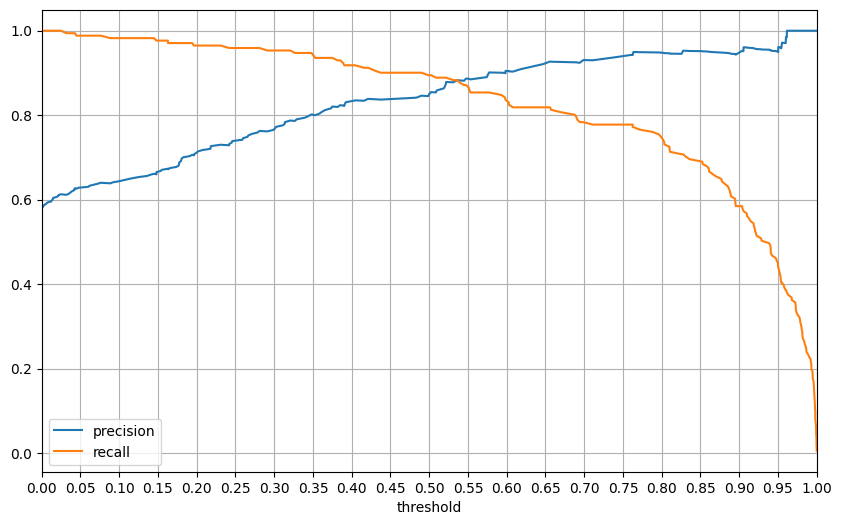

In [67]:
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precision[:-1], label='precision')
plt.plot(thresholds, recall[:-1], label='recall')

plt.xticks(np.arange(0, 1.05, 0.05))
plt.xlim([0, 1])

plt.xlabel('threshold')
plt.legend()
plt.grid(True)

### Question 4: F1 score

Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both

This is the formula for computing F1:

$$F_1 = 2 \cdot \cfrac{P \cdot R}{P + R}$$

Where $P$ is precision and $R$ is recall.

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01

At which threshold F1 is maximal?

- 0.14
- 0.34
- 0.54
- 0.74

In [71]:
f1_scores = {}

for idx in range(len(thresholds)):
    threshold = thresholds[idx]
    f1_scores[threshold] = 2 * precision[idx] * recall[idx] / (precision[idx] + recall[idx])

In [74]:
sorted(f1_scores.items(), key=lambda x: x[1], reverse=True)


[(np.float64(0.5217737832486514), np.float64(0.8837209302325582)),
 (np.float64(0.5364619528965933), np.float64(0.8830409356725146)),
 (np.float64(0.5213974209280052), np.float64(0.881159420289855)),
 (np.float64(0.5308593940207861), np.float64(0.880466472303207)),
 (np.float64(0.5392759052186367), np.float64(0.879765395894428)),
 (np.float64(0.5475919707728248), np.float64(0.8790560471976402)),
 (np.float64(0.5202543303185538), np.float64(0.8786127167630058)),
 (np.float64(0.5773963536478252), np.float64(0.876876876876877)),
 (np.float64(0.5449110506370212), np.float64(0.8764705882352941)),
 (np.float64(0.5189117846379092), np.float64(0.8760806916426512)),
 (np.float64(0.5509328841921567), np.float64(0.875739644970414)),
 (np.float64(0.4046799119359177), np.float64(0.8746518105849582)),
 (np.float64(0.3750326512511625), np.float64(0.8743169398907102)),
 (np.float64(0.5024374748336249), np.float64(0.8742857142857143)),
 (np.float64(0.5755909457435578), np.float64(0.874251497005988)),
 

### Question 5: 5-Fold CV


Use the `KFold` class from Scikit-Learn to evaluate our model on 5 different folds:

```
KFold(n_splits=5, shuffle=True, random_state=1)
```

* Iterate over different folds of `df_full_train`
* Split the data into train and validation
* Train the model on train with these parameters: `LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)`
* Use AUC to evaluate the model on validation

How large is standard deviation of the scores across different folds?

- 0.0001
- 0.006
- 0.06
- 0.36

In [75]:
from sklearn.model_selection import KFold

In [103]:
# def train(df_train, y_train, C=1.0, numerical_vars=numerical_vars, categorical_vars=categorical_vars):
#     X_train_num = df_train[numerical_vars]
#     scaler = StandardScaler()
#     X_train_num = scaler.fit_transform(X_train_num)

#     X_train_cat = df_train[categorical_vars]
#     train_dicts = X_train_cat.to_dict(orient='records')
#     dv = DictVectorizer(sparse=False)
#     X_train_cat = dv.fit_transform(train_dicts)

#     X_train = np.column_stack([X_train_num, X_train_cat])
    
#     model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
#     model.fit(X_train, y_train)

#     return scaler, dv, model

def train(df_train, y_train, C=1.0, numerical_vars=numerical_vars, categorical_vars=categorical_vars):
    X_train_num = df_train[numerical_vars]
    # scaler = StandardScaler()
    # X_train_num = scaler.fit_transform(X_train_num)

    X_train_cat = df_train[categorical_vars]
    train_dicts = X_train_cat.to_dict(orient='records')
    dv = DictVectorizer(sparse=False)
    X_train_cat = dv.fit_transform(train_dicts)

    X_train = np.column_stack([X_train_num, X_train_cat])
    
    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    model.fit(X_train, y_train)

    return dv, model



In [104]:
# def predict(df, scaler, dv, model, numerical_vars=numerical_vars, categorical_vars=categorical_vars):
#     X_num = df[numerical_vars]
#     X_num = scaler.transform(X_num)

#     X_cat = df[categorical_vars]
#     val_dicts = X_cat.to_dict(orient='records')
#     X_cat = dv.transform(val_dicts
#                              )
#     X = np.column_stack([X_num, X_cat])
#     y_pred_proba = model.predict_proba(X)[:, 1]
    
#     return y_pred_proba

def predict(df, dv, model, numerical_vars=numerical_vars, categorical_vars=categorical_vars):
    X_num = df[numerical_vars]
    # X_num = scaler.transform(X_num)

    X_cat = df[categorical_vars]
    val_dicts = X_cat.to_dict(orient='records')
    X_cat = dv.transform(val_dicts
                             )
    X = np.column_stack([X_num, X_cat])
    y_pred_proba = model.predict_proba(X)[:, 1]
    
    return y_pred_proba

In [105]:
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

scores = []

for train_idx, val_idx in kfold.split(df_full_train):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]

    y_train = df_train.converted.values
    y_val = df_val.converted.values

    df_train = df_train.drop(columns={'converted'})
    df_val = df_val.drop(columns={'converted'})

    # scaler, dv, model = train(df_train, y_train)
    dv, model = train(df_train, y_train)
    # y_pred_proba = predict(df_val, scaler, dv, model)
    y_pred_proba = predict(df_val, dv, model)

    auc = roc_auc_score(y_val, y_pred_proba)
    scores.append(auc)

In [106]:
scores

[0.8060745924216483,
 0.8713738368910783,
 0.7754320118852139,
 0.8018368617683685,
 0.8558272713202291]

In [107]:
np.std(scores)

np.float64(0.03580711942905165)

## Question 6: Hyperparameter Tuning

Now let's use 5-Fold cross-validation to find the best parameter `C`

* Iterate over the following `C` values: `[0.000001, 0.001, 1]`
* Initialize `KFold` with the same parameters as previously
* Use these parameters for the model: `LogisticRegression(solver='liblinear', C=C, max_iter=1000)`
* Compute the mean score as well as the std (round the mean and std to 3 decimal digits)

Which `C` leads to the best mean score?

- 0.000001
- 0.001
- 1


In [110]:
for C in [0.000001, 0.001, 1]:

    kfold = KFold(n_splits=5, shuffle=True, random_state=1)

    scores = []

    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train.converted.values
        y_val = df_val.converted.values

        df_train = df_train.drop(columns={'converted'})
        df_val = df_val.drop(columns={'converted'})

        dv, model = train(df_train, y_train, C=C)
        y_pred_proba = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred_proba)
        scores.append(auc)

    print(f'C={C:<8} AUC = {np.mean(scores):.3f} ± {np.std(scores):.3f}')    

C=1e-06    AUC = 0.560 ± 0.024
C=0.001    AUC = 0.867 ± 0.029
C=1        AUC = 0.822 ± 0.036
